# UNO: A COMPREHENSIVE ANALYSIS OF REINFORCEMENT LEARNING BASED AGENT

In [ ]:
# Import the required python libraries
import time
import random
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
import ipywidgets as widgets
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

In [ ]:
# Define the helper functions

def check_for_victory(agent):
  '''
  To check if the given player has won the game of UNO
  '''
  if len(agent.cards_in_hand):
    return False

  return True

In [ ]:
# Variable declaration

colors = ['RED', 'BLUE', 'GREEN', 'YELLOW']

numbered_cards = {'RED': 2,
                  'BLUE': 2,
                  'GREEN': 2,
                  'YELLOW': 2}

special_cards = {'SKIP': 2,
                  'DRAW2': 2,
                  'REVERSE': 2}
  
wild_cards = {'WILD': 2,
              'WILD+4': 2}

playable_numbered_cards = {'RED*': 1,
                           'BLUE*': 1,
                           'GREEN*': 1,
                           'YELLOW*': 1}

playable_special_cards = {'SKIP*': 1,
                          'DRAW2*': 1,
                          'REVERSE*': 1}

agent = None
algorithm = None


## Card

Each UNO card has two basic attributes:

1. Color: {Red, Blue, Green, Yellow}
2. Value: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}

Based on the current open card, a card can have two possible states:

1. Playable
2. Unplayable

In [ ]:
class Card():

  def __init__(self, color, value):
    '''
    To initialize the Card object's attributes
    '''
    self.color = color
    self.value = value


  def display(self):
    '''
    To print the card
    '''
    return str(self.color) + ' ' + str(self.value)


  def is_playable(self, open_card):
    '''
    To evaluate if the Card object is playable or not based on the current open card
    '''
    # Check for matching color or value or for the card being a wild card
    if (self.value in ['WILD', 'WILD+4']) or (self.color == open_card.color) or (self.value == open_card.value):
      return True

    return False

## Deck

An UNO deck consists of a total of 108 cards consisting of:

- 1 zero card of each color (4)
- 2 numbered cards of each color (72)
- 2 Skip cards of each color (8)
- 2 Draw Two cards of each color (8)
- 2 Reverse cards of each color (8)
- 4 Wild cards (4)
- 4 Wild Draw Four cards (4)

Note: Skip, Draw Two, and Reverse cards are termed as Action cards.

The UNO deck is shuffled at the beginning of every game.

Once all UNO cards are drawn from it, it is refilled/reset. 


In [ ]:
class Deck():
  
  def __init__(self):
    '''
    To initialize the Deck object's attributes
    '''
    self.available_cards = []
    self.cards_drawn = []
    self.create_deck()
    self.shuffle_deck()


  def show_deck(self):
    '''
    To display the available cards in the deck
    '''
    # Iterate over all the available cards
    for card in self.available_cards:

      # Display the card
      print(card.display())

    return


  def shuffle_deck(self):
    '''
    To shuffle the deck of UNO cards
    '''
    random.shuffle(self.available_cards)
    return


  def draw_a_card(self):
    '''
    To draw a card from the shuffled deck
    '''
    # Check for no available card 
    if not len(self.available_cards):
      self.create_deck()
      # self.available_cards = self.cards_drawn
      self.shuffle_deck()
      self.cards_drawn = []

    try:
      card_drawn = self.available_cards.pop()
    except:
      self.create_deck()
      card_drawn = self.available_cards.pop()


    return card_drawn


  def create_deck(self):
    '''
    To create a deck of UNO cards
    '''
    global colors

    self.available_cards = []

    # Define all variety of cards in the UNO deck
    zero_cards = [Card(color, 0) for color in colors]
    numbered_cards = [Card(color, value) for color in colors for value in range(1, 10)]
    skip_cards = [Card(color, 'SKIP') for color in colors]
    draw_two_cards = [Card(color, 'DRAW2') for color in colors]
    reverse_cards = [Card(color, 'REVERSE') for color in colors]
    wild_cards = [Card('WILD', value) for value in ['WILD', 'WILD+4']]

    # Create a deck using the above variety of UNO cards
    self.available_cards.extend(zero_cards)
    self.available_cards.extend(numbered_cards * 2)
    self.available_cards.extend(skip_cards * 2)
    self.available_cards.extend(draw_two_cards * 2)
    self.available_cards.extend(reverse_cards * 2)
    self.available_cards.extend(wild_cards * 4)

    return


  def remove_card(self, card):
    '''
    To remove the given card from the deck of available cards 
    '''
    if card in self.available_cards:
      self.cards_drawn.append(card)
    return


  def display_cards_drawn(self):
    '''
    To display the available cards in the deck
    '''
    # Iterate over all the cards drawn from the deck
    for card in self.cards_drawn:

      # Display the card
      print(card.display())

    return


## Implement the State-Action-Reward Mapping

In [ ]:
def get_all_states():
  '''
  To create and return an exhaustive list of all the possible states
  '''
  global numbered_cards, special_cards, wild_cards, playable_numbered_cards, playable_special_cards

  # Variable definition
  state_configuration = {**numbered_cards, **special_cards, **wild_cards, **playable_numbered_cards, **playable_special_cards}

  # Variable initialization
  all_colors = [colors]

  # For each color
  for i in state_configuration.values():

    # Create and append the state
    state_value = range(i + 1)
    all_colors.append(state_value)

  # Generate all the combinations
  all_colors = list(itertools.product(*all_colors))
  all_states = list()

  # For each state
  for i in range(len(all_colors)):

    # Filter out all the non-reachable states
    if (all_colors[i][1] >= all_colors[i][10]) and (all_colors[i][2] >= all_colors[i][11]) and (all_colors[i][3] >= all_colors[i][12]) and (all_colors[i][4] >= all_colors[i][13]) and (all_colors[i][5] >= all_colors[i][14]) and (all_colors[i][6] >= all_colors[i][15]) and (all_colors[i][7] >= all_colors[i][16]):
      all_states.append(all_colors[i])

  return all_states


def get_all_actions():
  """
  To create and return an exhaustive list of all feasible actions
  """
  return ['RED', 'BLUE', 'GREEN', 'YELLOW', 'SKIP', 'DRAW2', 'REVERSE', 'WILD', 'WILD+4']


def get_state_action_reward_table(all_states, all_actions):
  """
  To initialize the look-up table for rewards
  """
  # Variable initialization
  state_action_reward_table = np.zeros((len(all_states), len(all_actions)))
  state_initial_value = [min(sum(all_states[i][1:10]), 1) for i in range(len(all_states))]

  # For each reachable state
  for state in range(len(all_states)):
    if not state_initial_value[state]:
      state_action_reward_table[state] = 1

  state_action_reward_table = pd.DataFrame(state_action_reward_table, columns=all_actions, index=all_states)

  return state_action_reward_table

## Player

An UNO player has:
- a name
- card/s currently in hand
- playable card/s in hand, and
- a strategy

The strategy followed by a player (or agent in this case) depends upon the following factors:
- The current state of the player/agent 
- The possible actions that can be taken
- The decision making logic based on the type of agent (random, RL-based, etc.)


In [ ]:
class QLearningBasedAgent():
  '''
  To implement the Q-Learning based Reinforcement Learning approach for training the agent
  '''

  def initialize(self, agent_info):
    self.previous_state = 0
    self.previous_action = 0

    self.all_states = get_all_states()
    self.all_actions = get_all_actions()

    # Initialize the agent with the given parameters
    self.epsilon_threshold = agent_info['epsilon_threshold']
    self.step_size = agent_info['step_size']
    self.is_explored = agent_info['is_explored']

    self.state_action_reward_table = get_state_action_reward_table(self.all_states, self.all_actions)

    if self.is_explored:
      self.q_table = pd.DataFrame(np.zeros((len(self.all_states)), (len(self.all_actions))), index=self.all_states, columns=self.all_actions)
      self.visited = self.q_table.copy()

    else:
      # Try to re-use existing agent
      try:
        self.q_table = pd.read_csv('q_learning.csv', index_col='Unnamed: 0', sep=';')
        self.q_table.index = self.q_table.index.map(lambda i: eval(i))
        self.q_table['IDX'] = self.q_table.index
        self.q_table = self.q_table.set_index('IDX', drop=True)
        self.q_table.index.name = None

        self.visited = pd.read_csv('q_learning_visited.csv', index_col='Unnamed: 0', sep=';')
        self.visited.index = self.visited.index.map(lambda i: eval(i))
        self.visited['IDX'] = self.visited.index
        self.visited = self.visited.set_index('IDX', drop=True)
        self.visited.index.name = None

      # Create a new agent
      except:
        print('Initiating learning from scratch!')
        self.q_table = pd.DataFrame(np.zeros((len(self.all_states), len(self.all_actions))), index=self.all_states, columns=self.all_actions)
        self.visited = self.q_table.copy()


  def next_step(self, state_map, actions_map):
    '''
    To select the best possible next step given the above environment information
    '''
    feasible_actions = []
    feasible_action_values = []

    state_values = tuple([state_value for state_value in state_map.values()])
    random_value = random.random()

    # Iterate through and store all the feasible actions
    for feasible_action, action_value in actions_map.items():
      if action_value:
        feasible_actions.append(feasible_action)

    # Pick a random action
    if random_value < self.epsilon_threshold:
      selected_action = random.choice(feasible_actions)

    # Select the action greedily
    else:
      max_value = -999
      random.shuffle(feasible_actions)

      # Iterate through all the feasible actions
      for action in feasible_actions:
        current_value = self.q_table.loc[[state_values], action][0]

        # Find the action having the maximum value
        if current_value > max_value:
          max_value = current_value
          selected_action = action

    return selected_action


  def update_agent(self, state_map, selected_action):
    '''
    To update the Q values using the Belman equation
    '''
    state_values = tuple([state_value for state_value in state_map.values()])

    # Check if it is first turn
    if not self.previous_state:

      # Store the current state and respective action
      self.previous_state = state_values
      self.previous_action = selected_action

      return

    previous_q_value = self.q_table.loc[[self.previous_state], self.previous_action][0]
    current_q_value = self.q_table.loc[[state_values], selected_action][0]
    current_reward = self.state_action_reward_table.loc[[state_values], selected_action][0]

    # Calculate the updated Q values
    if current_reward:
      self.q_table.loc[[self.previous_state], self.previous_action] = previous_q_value + ((current_reward - previous_q_value) * self.step_size)

    else:
      self.q_table.loc[[self.previous_state], self.previous_action] = previous_q_value + ((current_reward + current_q_value - previous_q_value) * self.step_size)

    # Update the exploration count
    self.visited.loc[[self.previous_state], self.previous_action] = self.visited.loc[[self.previous_state], self.previous_action] + 1

    # Store the current state and respective action
    self.previous_state = state_values
    self.previous_action = selected_action

    return


In [ ]:
class MonteCarloBasedAgent():
  '''
  To implement the Q-Learning based Reinforcement Learning approach for training the agent
  '''

  def initialize(self, agent_info):
    self.explored_states = []
    self.explored_actions = []
    self.explored_q_values = []

    self.all_states = get_all_states()
    self.all_actions = get_all_actions()

    # Initialize the agent with the given parameters
    self.epsilon_threshold = agent_info['epsilon_threshold']
    self.step_size = agent_info['step_size']
    self.is_explored = agent_info['is_explored']

    self.state_action_reward_table = get_state_action_reward_table(self.all_states, self.all_actions)

    if self.is_explored:
      self.q_table = pd.DataFrame(np.zeros((len(self.all_states)), (len(self.all_actions))), index=self.all_states, columns=self.all_actions)
      self.visited = self.q_table.copy()

    else:
      # Try to re-use existing agent
      try:
        self.q_table = pd.read_csv('monte_carlo.csv', index_col='Unnamed: 0', sep=';')
        self.q_table.index = self.q_table.index.map(lambda i: eval(i))
        self.q_table['IDX'] = self.q_table.index
        self.q_table = self.q_table.set_index('IDX', drop=True)
        self.q_table.index.name = None

        self.visited = pd.read_csv('monte_carlo_visited.csv', index_col='Unnamed: 0', sep=';')
        self.visited.index = self.visited.index.map(lambda i: eval(i))
        self.visited['IDX'] = self.visited.index
        self.visited = self.visited.set_index('IDX', drop=True)
        self.visited.index.name = None

      # Create a new agent
      except:
        print('Initiating learning from scratch!')
        self.q_table = pd.DataFrame(np.zeros((len(self.all_states), len(self.all_actions))), index=self.all_states, columns=self.all_actions)
        self.visited = self.q_table.copy()


  def next_step(self, state_map, actions_map):
    '''
    To select the best possible next step given the above environment information
    '''
    feasible_actions = []
    feasible_action_values = []

    state_values = tuple([state_value for state_value in state_map.values()])
    random_value = random.random()

    # Iterate through and store all the feasible actions
    for feasible_action, action_value in actions_map.items():
      if action_value:
        feasible_actions.append(feasible_action)

    # Pick a random action
    if random_value < self.epsilon_threshold:
      selected_action = random.choice(feasible_actions)

    # Select the action greedily
    else:
      max_value = -999
      random.shuffle(feasible_actions)

      # Iterate through all the feasible actions
      for action in feasible_actions:
        current_value = self.q_table.loc[[state_values], action][0]

        # Find the action having the maximum value
        if current_value > max_value:
          max_value = current_value
          selected_action = action

    # Record the explored state and action information
    if ((state_values), selected_action) not in self.explored_q_values:
      self.explored_states.append(state_values)
      self.explored_actions.append(selected_action)

    self.explored_q_values.append(((state_values), selected_action))
    self.visited.loc[[state_values], selected_action] = self.visited.loc[[state_values], selected_action] + 1

    return selected_action


  def update_agent(self, state_map, selected_action):
    '''
    To update the Q values using the Belman equation
    '''
    state_values = tuple([state_value for state_value in state_map.values()])
    current_reward = self.state_action_reward_table.loc[[state_values], selected_action][0]

    # Update the Q-values of each step explored
    for state, action in zip(self.explored_states, self.explored_actions):
      self.q_table.loc[[state], action] = self.q_table.loc[[state], action] + (current_reward - self.q_table.loc[[state], action]) * self.step_size

    # Rest the required data structures
    self.state_seen = []
    self.action_seen = []
    self.q_seen = []

    return

In [ ]:
class Agent():
  '''
  To represent an UNO player and denote its state and set of actions
  '''

  def __init__(self, name):
    self.name = name
    self.previous_state = None
    self.cards_in_hand = []
    self.current_state = {}
    self.playable_cards = []
    self.possible_actions = {}
    self.action_taken = None
    self.card_played = None


  def display_cards_in_hand(self, verbose=False):
    '''
    To display the cards currently in the player's hand
    '''
    list_of_cards = []

    for card in self.cards_in_hand:
      list_of_cards.append(card.display())

    if verbose:
      print('{} has {} cards in hand: {}'.format(self.name, len(list_of_cards), ', '.join(list_of_cards)))

    return


  def display_playable_cards_in_hand(self, verbose=False):
    '''
    To display the cards currently in the player's hand
    '''
    list_of_playable_cards = []

    for card in self.playable_cards:
      list_of_playable_cards.append(card.display())

    if verbose:
      print('{} has {} playable cards in hand: {}'.format(self.name, len(list_of_playable_cards), ', '.join(list_of_playable_cards)))

    return


  def assess_cards_in_hand(self, open_card):
    '''
    To traverse through each card in hand and evaluate its usefulness 
    '''
    # Reset the list of playable cards
    self.playable_cards.clear()

    # Iterate through each card in hand
    for card_in_hand in self.cards_in_hand:

      # Check if the card is playable
      if card_in_hand.is_playable(open_card):
        self.playable_cards.append(card_in_hand)

    return


  def draw_a_card(self, deck, open_card, verbose=False):
    '''
    To add a card in the player's hand and re-evaluate
    '''
    # To draw a card from deck 
    new_card = deck.draw_a_card()

    # Add the new card in the list of cards in hand
    self.cards_in_hand.append(new_card)

    # To re-evaluate the list of cards in hand after drawing a card from the deck
    self.assess_cards_in_hand(open_card)

    if verbose:
      print('{} draws {}'.format(self.name, new_card.display()))

    return


  def get_current_state(self, open_card):
    '''
    To recognize the current state the player is in by viewing the cards in play
    '''
    global colors, numbered_cards, special_cards, wild_cards, playable_numbered_cards, playable_special_cards

    self.current_state = {}
    self.current_state['open_card'] = open_card.color

    if self.current_state['open_card'] not in colors:
      random.choice(colors)

    # Count the numbered cards for each color
    for color, max_count in numbered_cards.items():
      count = 0

      # Traverse through the list of cards in hand
      for card in self.cards_in_hand:

        # Check if the card matches the required property
        if card.color == color and card.value in range(10):
          count += 1

      # Restrict the state space
      self.current_state[color] = min(max_count, count)

    # Count the special cards for each color
    for special_card, max_count in special_cards.items():
      count = 0

      # Traverse through the list of cards in hand
      for card in self.cards_in_hand:

        # Check if the card matches the required property
        if card.value == special_card:
          count += 1

      # Restrict the state space
      self.current_state[special_card] = min(max_count, count)

    # Count the wild cards for each color
    for wild_card, max_count in wild_cards.items():
      count = 0

      # Traverse through the list of cards in hand
      for card in self.cards_in_hand:

        # Check if the card matches the required property
        if card.value == wild_card:
          count += 1

      # Restrict the state space
      self.current_state[wild_card] = min(max_count, count)

    # Count the total numbered cards that are playable
    for color, max_count in playable_numbered_cards.items():
      count = 0

      # Traverse through the list of cards in hand
      for card in self.playable_cards:

        # Check if the card matches the required property
        if card.color == color and card.value in range(10):
          count += 1

      # Restrict the state space
      self.current_state[color] = min(max_count, count)

    # Count the total special cards that are playable
    for special_card, max_count in playable_special_cards.items():
      count = 0

      # Traverse through the list of cards in hand
      for card in self.playable_cards:

        # Check if the card matches the required property
        if card.value == special_card:
          count += 1

      # Restrict the state space
      self.current_state[special_card] = min(max_count, count)

    return


  def fetch_action(self):
    '''
    To fetch all the possible actions that can be taken by the player 
    '''
    global colors, numbered_cards, special_cards, wild_cards, playable_numbered_cards, playable_special_cards

    # Count the total numbered cards that are playable
    for color, max_count in numbered_cards.items():
      count = 0

      # Traverse through the list of cards in hand
      for card in self.playable_cards:

        # Check if the card matches the required property
        if card.color == color and card.value in range(10):
          count += 1

      # Restrict the state space
      self.possible_actions[color] = min(max_count, count)

    # Count the total special cards that are playable
    for special_card, max_count in special_cards.items():
      count = 0

      # Traverse through the list of cards in hand
      for card in self.playable_cards:

        # Check if the card matches the required property
        if card.value == special_card:
          count += 1

      # Restrict the state space
      self.possible_actions[special_card] = min(max_count, count)

    # Count the total wild cards that are playable
    for wild_card, max_count in wild_cards.items():
      count = 0

      # Traverse through the list of cards in hand
      for card in self.playable_cards:

        # Check if the card matches the required property
        if card.value == wild_card:
          count += 1

      # Restrict the state space
      self.possible_actions[wild_card] = min(max_count, count)

    return


  def pick_color_for_random_agent(self):
    '''
    To choose a color for the random agent upon playing a wild card
    '''
    global colors
    return random.choice(colors)


  def pick_color_for_card_counting_agent(self):
    '''
    To choose a color for the card counting agent upon playing a wild card
    '''
    global colors
    card_colors = []
    color_weights = []

    # For each card in hand
    for card in self.cards_in_hand:

      # Check for wild card
      if card.color == 'WILD':
        continue

      card_colors.append(card.color)

    distinct_colors = list(set(card_colors))

    # Make the decision
    if len(distinct_colors):
      for card_color in distinct_colors:
        color_weights.append(distinct_colors.count(card_color))
      return random.choices(distinct_colors, weights=color_weights, k=1)[0]
  
    return random.choice(colors)


  def pick_color_for_rl_based_agent(self):
    '''
    To choose a color for the Reinforcement Learning based agent upon playing a wild card
    '''
    global colors

    card_colors = []
    colors_in_hand = []

    for card in self.cards_in_hand:
      if card.color in colors:
        colors_in_hand.append(card.color)

    if len(colors_in_hand):
      most_likely_color = max(colors_in_hand, key=colors_in_hand.count)
    else:
      most_likely_color = random.choice(colors)

    return most_likely_color


  def move_by_random_agent(self, deck):
    '''
    To represent the random agent's move  
    '''
    # Shuffle the playable cards in hand
    random.shuffle(self.playable_cards)

    # Select a playable card
    self.card_played = self.playable_cards.pop()
    self.cards_in_hand.remove(self.card_played)
    deck.remove_card(self.card_played)

    # Check if the selected card is a wild card
    if self.card_played.value in ['WILD', 'WILD+4']:
      self.card_played.color = self.pick_color_for_random_agent()

    return


  def move_by_card_counting_agent(self, deck, open_card):
    '''
    To represent the random agent's move  
    '''
    self.assess_cards_in_hand(open_card)

    card_weights = []

    # Shuffle the playable cards in hand
    random.shuffle(self.playable_cards)

    # For each playable card in hand
    for card in self.playable_cards:

      # Calculate the weight of that card
      card_weights.append(deck.count_card(card))

    # Select a playable card
    self.card_played = random.choices(self.playable_cards, weights=card_weights, k=1)[0]
    self.cards_in_hand.remove(self.card_played)
    deck.remove_card(self.card_played)

    # Check if the selected card is a wild card
    if self.card_played.color == 'WILD':
      self.card_played.color = self.pick_color_for_card_counting_agent()

    return


  def move_by_rl_based_agent(self, deck, open_card):
    '''
    To represent the Reinforcement Learning based agent's move
    '''
    global agent, algorithm

    # Identify the player's state and potential actions
    self.get_current_state(open_card)
    self.fetch_action()
    self.action_taken = agent.next_step(self.current_state, self.possible_actions)

    # Check if optimal card is a Wild card
    if self.action_taken in ['WILD', 'WILD+4']:

      # Check if the optimal card exists in hand
      for card in self.cards_in_hand:
        if card.value == self.action_taken:
          break

    # Check if optimal card is of different color
    elif self.action_taken in colors and self.action_taken != open_card.color:

      # Check if the optimal card exists in hand
      for card in self.cards_in_hand:
        if card.color == self.action_taken and card.value == open_card.value:
          break

    # Check if optimal card is of same color
    elif self.action_taken in colors and self.action_taken == open_card.color:

      # Check if the optimal card exists in hand
      for card in self.cards_in_hand:
        if card.color == self.action_taken and card.value in range(10):
          break

    # Check if optimal card is special card of same color
    elif self.action_taken not in colors and self.action_taken != open_card.value:

      # Check if the optimal card exists in hand
      for card in self.cards_in_hand:
        if card.color == open_card.color and card.value == self.action_taken:
          break

    # Check if optimal card is special card of different color
    else:

      # Check if the optimal card exists in hand
      for card in self.cards_in_hand:
        if card.value == self.action_taken:
          break

    # Play the selected card
    self.card_played = card
    self.cards_in_hand.remove(card)
    self.playable_cards.pop()
    deck.remove_card(card)

    if self.card_played.value in ['WILD', 'WILD+4']:
      self.card_played.color = self.pick_color_for_rl_based_agent()

    if algorithm == 'Q Learning':
      agent.update_agent(self.current_state, self.action_taken)

    return



## Turn

This represents players' action. The term 'active player' refers to the player whose turn it is.

Note: This is the class in focus when it comes to analysing different strategies. The player's action will depend on whether it is a random agent, a card counting agent, or a reinforcement learning based agent.

In [ ]:
class Turn:
  '''
  To represent the players' actions throughout the course of a game
  '''

  def __init__(self, deck, agent_1, agent_2, scenario):
    self.deck = deck
    self.agent_1 = agent_1
    self.agent_2 = agent_2
    self.scenario = scenario
    self.open_card = self.deck.draw_a_card()
    self.begin_game()


  def begin_game(self, verbose=False):
    '''
    To start the game of UNO
    '''
    # Open a numbered card
    while self.open_card.value not in range(10):
      self.open_card = self.deck.draw_a_card()

    if verbose:
      print('Starting card is {}'.format(self.open_card.display()))

    # Distribute the initial 7 cards
    for _ in range(7):
      self.agent_1.draw_a_card(self.deck, self.open_card)
      self.agent_2.draw_a_card(self.deck, self.open_card)

    return


  def move(self, active_agent, opponent, verbose=False):
    '''
    To represent the active player's turn
    '''
    active_agent.assess_cards_in_hand(self.open_card)

    # Check if the active player can play a card directly
    if len(active_agent.playable_cards):

      # RLBased Agent vs Randumb Agent
      if self.scenario == 1:
        # Check the nature of active player
        if active_agent == self.agent_1:
          active_agent.move_by_rl_based_agent(self.deck, self.open_card)
        else:
          active_agent.move_by_random_agent(self.deck)

      if self.scenario == 2:
        # Check the nature of active player
        if active_agent == self.agent_1:
          active_agent.move_by_rl_based_agent(self.deck, self.open_card)
        else:
          active_agent.move_by_random_agent(self.deck, self.open_card)

      if self.scenario == 3:
        # Check the nature of active player
        if active_agent == self.agent_1:
          active_agent.move_by_rl_based_agent(self.deck, self.open_card)
        else:
          active_agent.move_by_card_counting_agent(self.deck, self.open_card)

      # Update the open card
      self.open_card = active_agent.card_played
      active_agent.assess_cards_in_hand(self.open_card)

    # Check if the active player needs to draw a card from the deck
    else:

      # Draw a card from the deck
      if verbose:
        print('{} has no playable card'.format(active_agent.name))
  
      active_agent.draw_a_card(self.deck, self.open_card)

      # Check if the active player doesn't draw a playable card
      if len(active_agent.playable_cards):

        # Check the nature of active player
        if active_agent == self.agent_1:
          active_agent.move_by_rl_based_agent(self.deck, self.open_card)

        elif active_agent == self.agent_2:
          active_agent.move_by_random_agent(self.deck)

        # Update the open card
        self.open_card = active_agent.card_played
        active_agent.assess_cards_in_hand(self.open_card)

      else:
        active_agent.card_played = Card(0, 0)

    # Check if the active player wins
    if check_for_victory(active_agent):
      return

    # Check if the opponent wins
    if check_for_victory(opponent):
      return

    if verbose:
      print('>>> {} Plays {}'.format(active_agent.name, active_agent.card_played.display()))

    # Check for a draw 2 card being played
    if active_agent.card_played.value == 'DRAW2':
      opponent.draw_a_card(self.deck, self.open_card)
      opponent.draw_a_card(self.deck, self.open_card)

    # Check for a Wild draw 4 card being played
    elif active_agent.card_played.value == 'WILD+4':
      opponent.draw_a_card(self.deck, self.open_card)
      opponent.draw_a_card(self.deck, self.open_card)
      opponent.draw_a_card(self.deck, self.open_card)
      opponent.draw_a_card(self.deck, self.open_card)

    return


## Gameplay

The game of UNO consists of playing cards in a an episodic manner, i.e. in a series of turns. These iterations continue until one player emerges as the winner by having no cards in hand.

In [ ]:
class GamePlay():
  '''
  To represent a complete game of UNO
  '''

  def __init__(self, agent_1_name, agent_2_name, agent_to_begin_game, scenario, verbose=False):
    global agent

    self.winner = None
    self.count_of_turns = 0

    self.agent_1 = Agent(agent_1_name)
    self.agent_2 = Agent(agent_2_name)
    self.turn = Turn(Deck(), self.agent_1, self.agent_2, scenario)

    if verbose:
      print('------------------------------')

    # Keep iterating until the winner is decided
    while not self.winner:
      self.count_of_turns = self.count_of_turns + 1

      # Store the card currently on top of stack
      open_card = self.turn.open_card

      if verbose:
        print('Turn: {} | Open Card: {}'.format(self.count_of_turns, open_card.display()))

      # Check the starting player
      if agent_to_begin_game == self.agent_1.name:

        # Check for which player is to make move
        if self.count_of_turns % 2:
          active_agent = self.agent_1
          opponent = self.agent_2

        else:
          active_agent = self.agent_2
          opponent = self.agent_1

      elif agent_to_begin_game == self.agent_2.name:

        # Check for which player is to make move
        if self.count_of_turns % 2:
          active_agent = self.agent_2
          opponent = self.agent_1

        else:
          active_agent = self.agent_1
          opponent = self.agent_2

      active_agent.display_cards_in_hand()
      active_agent.display_playable_cards_in_hand()
      self.turn.move(active_agent, opponent)

      # Check if the game has ended
      if check_for_victory(active_agent):
        self.winner = active_agent.name
        if verbose:
          print('{} WON!!!'.format(self.winner))
        break

      elif check_for_victory(opponent):
        self.winner = opponent.name
        if verbose:
          print('{} WON!!!'.format(self.winner))
        break

      if active_agent.card_played.value in ["REVERSE", "SKIP"]:
        self.count_of_turns -= 1
          
      # if (self.count_of_turns > 0) and (self.count_of_turns % 2 == 0):
      #   self.count_of_turns -= 1

      if verbose:
        print(len(self.turn.deck.available_cards))
        print('------------------------------')

    self.agent_1.get_current_state(open_card)
    agent.update_agent(self.agent_1.current_state, self.agent_1.action_taken)

    return



## Simulations

This is the final step at the top of the code-flow hierarchy where multiple rounds of UNO are simulated between different sets of agents and the metrics are recorded for analysis. 

In [ ]:
def run_simulations(number_of_rounds, rl_approach, scenario, verbose, agent_info, agent_1_name, agent_2_name):
  '''
  To run simulations and record multiple rounds of UNO
  '''
  start_time = time.time()

  global agent, algorithm

  # Define the agent behavior
  if rl_approach != 'NONE':
    if rl_approach == 'Q Learning':
      agent = QLearningBasedAgent()
    else:
      agent = MonteCarloBasedAgent()

  algorithm = rl_approach

  rounds = []
  state_coverage = []
  winners = []

  # Initialize the game agent
  agent.initialize(agent_info)

  for i in tqdm(range(number_of_rounds)):
    time.sleep(0.05)

    if i%2:
      uno_round = GamePlay(agent_1_name=agent_1_name, agent_2_name=agent_2_name, agent_to_begin_game=agent_1_name, scenario=scenario, verbose=False)

    else:
      uno_round = GamePlay(agent_1_name=agent_1_name, agent_2_name=agent_2_name, agent_to_begin_game=agent_2_name, scenario=scenario, verbose=False)
    
    rounds.append(uno_round.count_of_turns)
    state_coverage.append((agent.q_table != 0).values.sum())
    winners.append(uno_round.winner)

  end_time = time.time()
  time_period = end_time - start_time
  minutes = time_period // 60
  seconds = round(time_period - (minutes * 60))
  print('Simulation of {} rounds ran for {} minutes and {} seconds'.format(number_of_rounds, minutes, seconds))

  return rounds, state_coverage, winners


## Configure Simulations

In [ ]:
# Widgets for settings
number_of_simulations_widget = widgets.IntText(value=10000, description = "Total Simulations:")
algorithm_widget = widgets.Dropdown(options=["Monte Carlo", "Q Learning"], value="Q Learning", description="Algorithm:")
is_explored_widget = widgets.Dropdown(options=[True, False], value=True, description="New Model:")
verbose_widget   = widgets.Dropdown(options=[True, False], value=False, description="Verbose:")

# Widgets for parameters
epsilon_threshold_widget = widgets.FloatSlider(value=0.2, min=0, max=1, step=0.01, description="Epsilson:", readout_format=".2f")
step_size_widget = widgets.FloatSlider(value=0.2, min=0, max=1, step=0.01, description="Step Size:", readout_format=".2f")

# Display the above widgets
print('Configure Simulations:')
print('----------------------------------------')
display(number_of_simulations_widget)
display(algorithm_widget)
display(is_explored_widget)
display(verbose_widget)
display(epsilon_threshold_widget)
display(step_size_widget)

Configure Simulations:
----------------------------------------


IntText(value=10000, description='Total Simulations:')

Dropdown(description='Algorithm:', index=1, options=('Monte Carlo', 'Q Learning'), value='Q Learning')

Dropdown(description='New Model:', options=(True, False), value=True)

Dropdown(description='Verbose:', index=1, options=(True, False), value=False)

FloatSlider(value=0.2, description='Epsilson:', max=1.0, step=0.01)

FloatSlider(value=0.2, description='Step Size:', max=1.0, step=0.01)

## Trigger Simulations

In [ ]:
# Variable declaration
turns = []
state_coverage = []
winners = []

# Define the RL-based agent parameters
rl_based_agent_info = {'epsilon_threshold': 0.2,
                       'step_size': 0.2,
                       'is_explored': False}

agent_1_name = 'RLBased'
agent_2_name = 'Randumb'

trigger_simulations = run_simulations(number_of_rounds=number_of_simulations_widget.value,
                                      rl_approach=algorithm_widget.value,
                                      scenario=1, 
                                      verbose=verbose_widget.value, 
                                      agent_info=rl_based_agent_info,
                                      agent_1_name=agent_1_name,
                                      agent_2_name=agent_2_name)

turns.extend(trigger_simulations[0])
state_coverage.extend(trigger_simulations[1])
winners.extend(trigger_simulations[2])

# winners

Initiating learning from scratch!


  0%|          | 0/10000 [00:00<?, ?it/s]

Simulation of 10000 rounds ran for 36.0 minutes and 40 seconds


In [ ]:
len(turns)

10000

## Dominance Analysis

Total games played: 10000
Total games won by RLBased: 5353 (53.53%)
Total games won by Randumb: 4647 (46.47%)


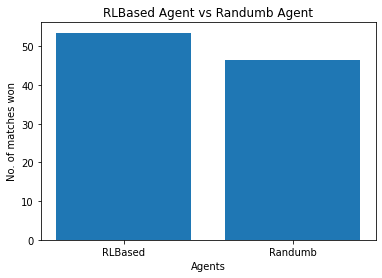

In [ ]:
total_games = len(winners)
rlbased_victories = winners.count(agent_1_name)
randumb_victories = winners.count(agent_2_name)

rlbased_victory_percentage = round(100 * rlbased_victories / total_games, 2)
randumb_victory_percentage = round(100 * randumb_victories / total_games, 2)

print('Total games played: {}'.format(total_games))
print('Total games won by {}: {} ({}%)'.format(agent_1_name, rlbased_victories, rlbased_victory_percentage))
print('Total games won by {}: {} ({}%)'.format(agent_2_name, randumb_victories, randumb_victory_percentage))

# Visualize the ratio of matches won by each agent
plt.bar(['RLBased', 'Randumb'], [rlbased_victory_percentage, randumb_victory_percentage])
plt.xlabel('Agents')
plt.ylabel('No. of matches won')
plt.title('RLBased Agent vs Randumb Agent')
plt.show()

## Total Turns per Game

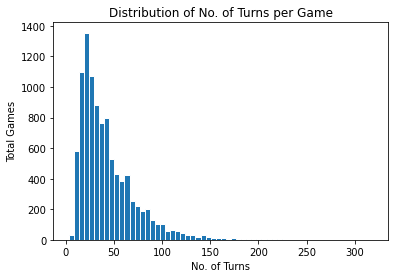

In [ ]:
# Plot the graph
plt.hist(turns, bins=60, edgecolor = "w")
plt.xlabel("No. of Turns")
plt.ylabel("Total Games")
plt.title('Distribution of No. of Turns per Game')
plt.show()

## Cumulative Win Rate Analysis

In [ ]:
# Create a new DataFrame
win_rate_analysis = pd.concat([pd.Series(winners), pd.Series(turns)], axis = 1).rename(columns={0:'Winner', 1:'No. of Turns'})

# Calculate the sequentially cumulative win rate
win_rate_analysis['Win Rate %age'] = win_rate_analysis['Winner'].apply(lambda x: 1 if x == "RLBased" else 0)
win_rate_analysis['Win Rate %age'] = win_rate_analysis['Win Rate %age'].cumsum() / (win_rate_analysis.index + 1)
win_rate_analysis['Win Rate %age'] = win_rate_analysis['Win Rate %age'].apply(lambda x: round(100 * x, 2))

# Display the results
win_rate_analysis.tail(10)

,Winner,No. of Turns,Win Rate %age
9990,RLBased,40,53.50
9991,RLBased,99,53.50
9992,Randumb,79,53.50
9993,RLBased,45,53.50
9994,RLBased,10,53.51
9995,RLBased,33,53.51
9996,RLBased,36,53.52
9997,RLBased,19,53.52
9998,RLBased,24,53.53
9999,RLBased,25,53.53


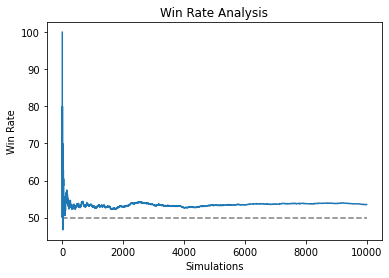

In [ ]:
plt.plot(win_rate_analysis.index, win_rate_analysis["Win Rate %age"])
plt.hlines(50, 0, len(winners), colors="grey", linestyles="dashed")
plt.title("Win Rate Analysis")
plt.xlabel("Simulations")
plt.ylabel("Win Rate")
plt.show()

## Q-Table

In [ ]:
q_table = pd.DataFrame(agent.q_table)
q_table["IDX"] = q_table.index
q_table = q_table.set_index("IDX", drop=True)
q_table.index.name = None
q_table

,RED,BLUE,GREEN,YELLOW,SKIP,DRAW2,REVERSE,WILD,WILD+4
"(RED, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)",0.045287,0.062334,0.027115,0.038202,0.020329,0.036592,0.025836,0.0,0.0
"(RED, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0)",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.2
"(RED, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0)",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
"(RED, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0)",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
"(RED, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0)",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
...,...,...,...,...,...,...,...,...,...
"(YELLOW, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 0, 1, 1)",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
"(YELLOW, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 0, 0)",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
"(YELLOW, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 0, 1)",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
"(YELLOW, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 0)",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0


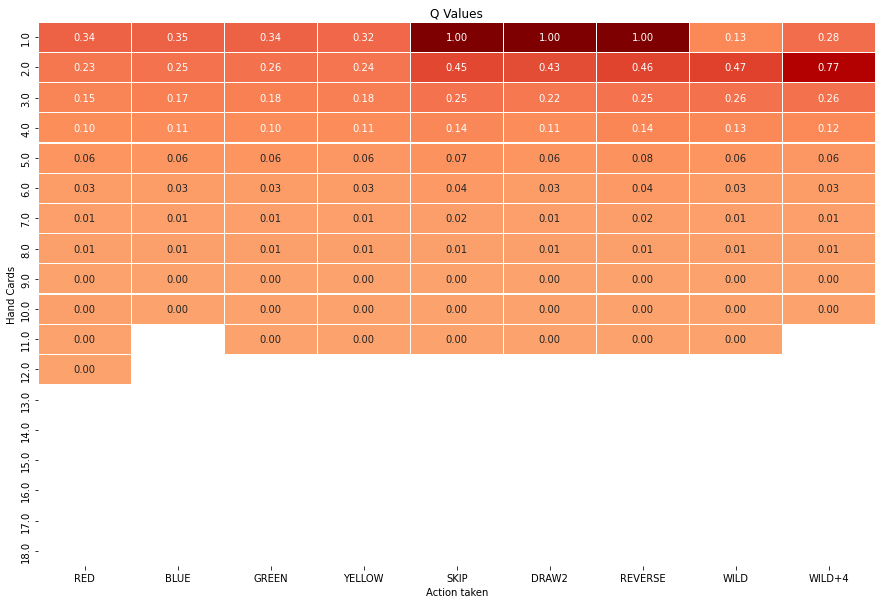

In [ ]:
q_pivot = q_table.copy()

# Data prep
q_pivot["HAND"] = q_pivot.index.map(lambda x: sum(x[1:10]))
q_pivot = q_pivot.replace(0, np.NaN)
q_pivot = q_pivot.groupby("HAND").mean()


# Plotting
fig, ax = plt.subplots(1, 1, figsize = (15,10))

sns.heatmap(q_pivot, 
            fmt=".2f", 
            cmap = "OrRd", 
            linewidth = 0.3, 
            annot = True,
            cbar = False,
            center = 0.1)

ax.title.set_text("Q Values")
ax.set(xlabel="Action taken", ylabel="Hand Cards")
plt.show()

In [ ]:
q_visited = (q_table != 0).values.sum()
q_possible = 0

for i in range(len(q_table)):
    q_possible += sum(q_table.index[i][8:])
    
print (f'From {q_possible:,} possible combinations {q_visited:,} or {q_visited/q_possible*100:.2f}% have been visited')

From 13,500,000 possible combinations 16,646 or 0.12% have been visited


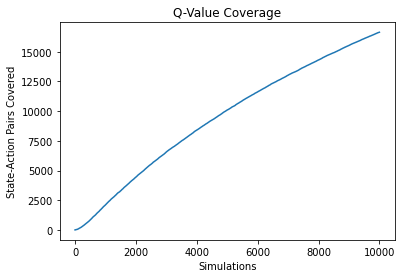

In [ ]:
plt.plot(pd.Series(state_coverage))
plt.xlabel("Simulations")
plt.ylabel("State-Action Pairs Covered")
plt.title("Q-Value Coverage")
plt.show()

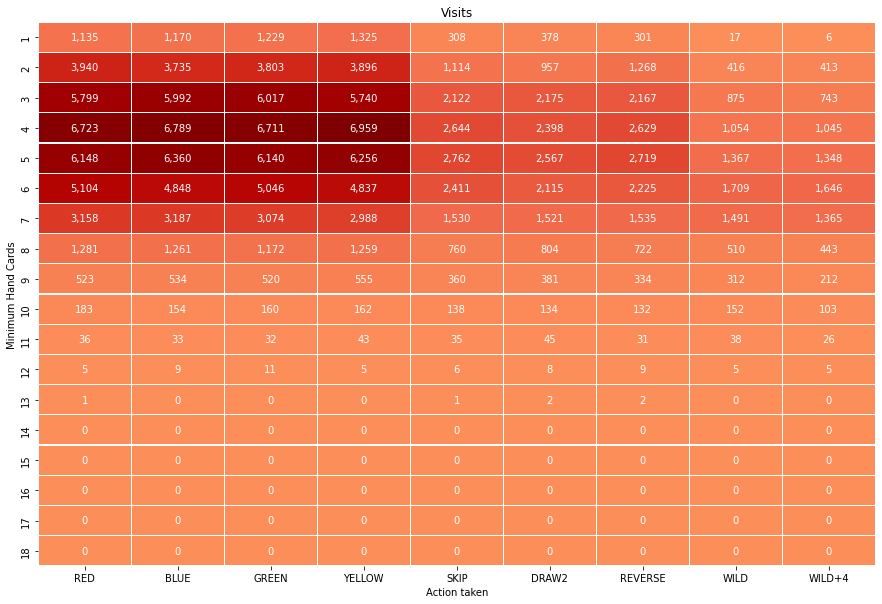

In [ ]:
visit = agent.visited.copy()

# Data prep
visit["HAND"] = visit.index.map(lambda x: sum(x[1:10]))
visit = visit.replace(0, np.NaN)
visit = visit.groupby("HAND").sum()
visit.index = visit.index.astype(int)


# Plotting
fig, ax = plt.subplots(1, 1, figsize = (15,10))

sns.heatmap(visit, 
            fmt= ",.0f", 
            cmap = "OrRd", 
            linewidth = 0.3, 
            annot = True,
            cbar = False,
            center = 0.1)

ax.title.set_text("Visits")
ax.set(xlabel="Action taken", ylabel="Minimum Hand Cards")
plt.show()

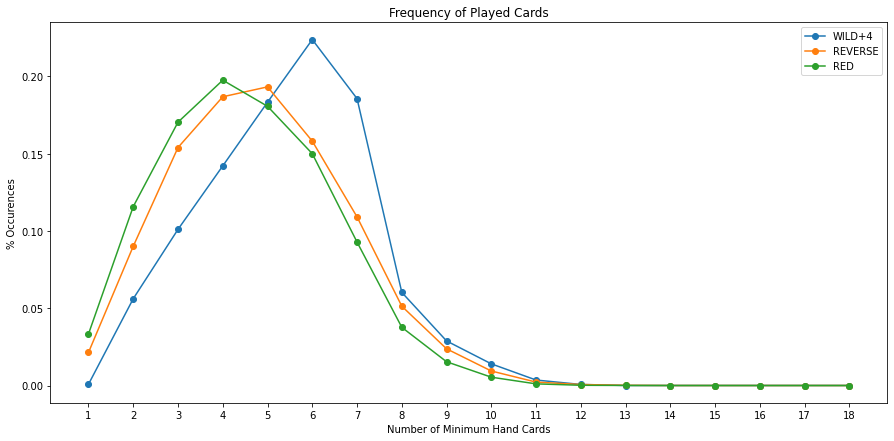

In [ ]:
card_type = ["WILD+4","REVERSE","RED"]

# Plotting
fig = plt.figure(1, figsize=(15,7))

for i in card_type:
    temp = visit[i]/sum(visit[i])
    plt.plot(temp.index, temp, label=i, marker = "o")


# Formatting
plt.xticks(temp.index)
plt.xlabel("Number of Minimum Hand Cards")
plt.ylabel("% Occurences")
plt.title("Frequency of Played Cards")
plt.legend()
plt.show()

In [ ]:
q_learning_metrics = {'winners': winners,
                      'turns': turns,
                      'state_coverage': state_coverage}

In [ ]:
# Widgets for settings
number_of_simulations_widget = widgets.IntText(value=400, description = "#Simulations:")
algorithm_widget = widgets.Dropdown(options=["Monte Carlo", "Q Learning"], value="Monte Carlo", description="Algorithm:")
is_explored_widget = widgets.Dropdown(options=[True, False], value=True, description="New Model:")
verbose_widget   = widgets.Dropdown(options=[True, False], value=False, description="Verbose:")

# Widgets for parameters
epsilon_threshold_widget = widgets.FloatSlider(value=0.2, min=0, max=1, step=0.01, description="Epsilson:", readout_format=".2f")
step_size_widget = widgets.FloatSlider(value=0.2, min=0, max=1, step=0.01, description="Step Size:", readout_format=".2f")

# Display the above widgets
print('Configure Simulations:')
print('----------------------------------------')
display(number_of_simulations_widget)
display(algorithm_widget)
display(is_explored_widget)
display(verbose_widget)
display(epsilon_threshold_widget)
display(step_size_widget)

Configure Simulations:
----------------------------------------


IntText(value=400, description='Total Simulations:')

Dropdown(description='Algorithm:', options=('Monte Carlo', 'Q Learning'), value='Monte Carlo')

Dropdown(description='New Model:', options=(True, False), value=True)

Dropdown(description='Verbose:', index=1, options=(True, False), value=False)

FloatSlider(value=0.2, description='Epsilson:', max=1.0, step=0.01)

FloatSlider(value=0.2, description='Step Size:', max=1.0, step=0.01)

In [ ]:
# Variable declaration
turns = []
state_coverage = []
winners = []

# Define the RL-based agent parameters
rl_based_agent_info = {'epsilon_threshold': 0.2,
                       'step_size': 0.2,
                       'is_explored': False}

agent_1_name = 'RLBased'
agent_2_name = 'Randumb'

trigger_simulations = run_simulations(number_of_rounds=number_of_simulations_widget.value,
                                      rl_approach=algorithm_widget.value,
                                      scenario=1, 
                                      verbose=verbose_widget.value, 
                                      agent_info=rl_based_agent_info,
                                      agent_1_name=agent_1_name,
                                      agent_2_name=agent_2_name)

turns.extend(trigger_simulations[0])
state_coverage.extend(trigger_simulations[1])
winners.extend(trigger_simulations[2])

# winners

Initiating learning from scratch!


  0%|          | 0/400 [00:00<?, ?it/s]

Simulation of 400 rounds ran for 35.0 minutes and 16 seconds


## Dominance Analysis

Total games played: 400
Total games won by RLBased: 219 (54.75%)
Total games won by Randumb: 181 (45.25%)


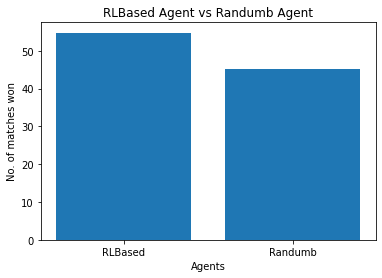

In [ ]:
total_games = len(winners)
rlbased_victories = winners.count(agent_1_name)
randumb_victories = winners.count(agent_2_name)

rlbased_victory_percentage = round(100 * rlbased_victories / total_games, 2)
randumb_victory_percentage = round(100 * randumb_victories / total_games, 2)

print('Total games played: {}'.format(total_games))
print('Total games won by {}: {} ({}%)'.format(agent_1_name, rlbased_victories, rlbased_victory_percentage))
print('Total games won by {}: {} ({}%)'.format(agent_2_name, randumb_victories, randumb_victory_percentage))

# Visualize the ratio of matches won by each agent
plt.bar(['RLBased', 'Randumb'], [rlbased_victory_percentage, randumb_victory_percentage])
plt.xlabel('Agents')
plt.ylabel('No. of matches won')
plt.title('RLBased Agent vs Randumb Agent')
plt.show()

## Total Turns per Game

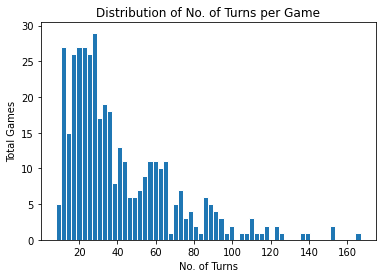

In [ ]:
# Plot the graph
plt.hist(turns, bins=60, edgecolor = "w")
plt.xlabel("No. of Turns")
plt.ylabel("Total Games")
plt.title('Distribution of No. of Turns per Game')
plt.show()

## Cumulative Win Rate Analysis

In [ ]:
# Create a new DataFrame
win_rate_analysis = pd.concat([pd.Series(winners), pd.Series(turns)], axis = 1).rename(columns={0:'Winner', 1:'No. of Turns'})

# Calculate the sequentially cumulative win rate
win_rate_analysis['Win Rate %age'] = win_rate_analysis['Winner'].apply(lambda x: 1 if x == "RLBased" else 0)
win_rate_analysis['Win Rate %age'] = win_rate_analysis['Win Rate %age'].cumsum() / (win_rate_analysis.index + 1)
win_rate_analysis['Win Rate %age'] = win_rate_analysis['Win Rate %age'].apply(lambda x: round(100 * x, 2))

# Display the results
win_rate_analysis.tail(10)

,Winner,No. of Turns,Win Rate %age
390,RLBased,18,54.22
391,RLBased,27,54.34
392,RLBased,26,54.45
393,Randumb,18,54.31
394,RLBased,12,54.43
395,Randumb,22,54.29
396,RLBased,22,54.41
397,RLBased,59,54.52
398,RLBased,86,54.64
399,RLBased,19,54.75


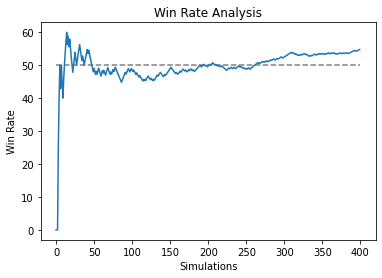

In [ ]:
plt.plot(win_rate_analysis.index, win_rate_analysis["Win Rate %age"])
plt.hlines(50, 0, len(winners), colors="grey", linestyles="dashed")
plt.title("Win Rate Analysis")
plt.xlabel("Simulations")
plt.ylabel("Win Rate")
plt.show()

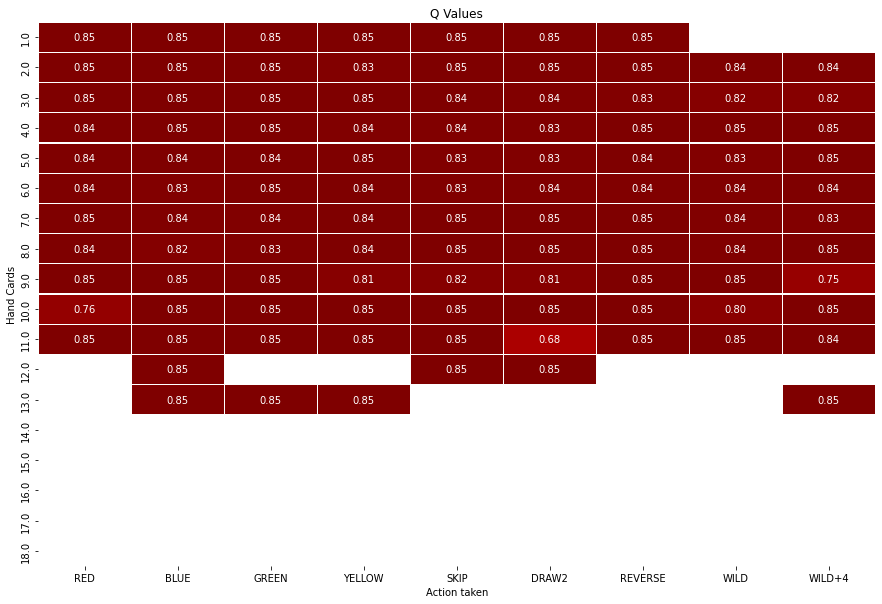

In [ ]:
q_pivot = q_table.copy()

# Data prep
q_pivot["HAND"] = q_pivot.index.map(lambda x: sum(x[1:10]))
q_pivot = q_pivot.replace(0, np.NaN)
q_pivot = q_pivot.groupby("HAND").mean()


# Plotting
fig, ax = plt.subplots(1, 1, figsize = (15,10))

sns.heatmap(q_pivot, 
            fmt=".2f", 
            cmap = "OrRd", 
            linewidth = 0.3, 
            annot = True,
            cbar = False,
            center = 0.1)

ax.title.set_text("Q Values")
ax.set(xlabel="Action taken", ylabel="Hand Cards")
plt.show()

## Q-value Coverage Analysis

In [ ]:
q_visited = (q_table != 0).values.sum()
q_possible = 0

for i in range(len(q_table)):
    q_possible += sum(q_table.index[i][8:])
    
print (f'From {q_possible:,} possible combinations {q_visited:,} or {q_visited/q_possible*100:.2f}% have been visited')

From 13,500,000 possible combinations 3,952 or 0.03% have been visited


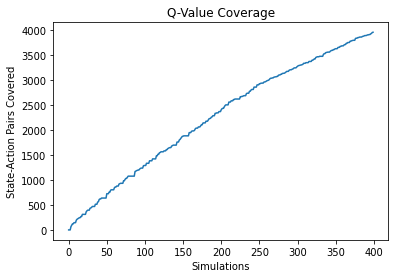

In [ ]:
plt.plot(pd.Series(state_coverage))
plt.xlabel("Simulations")
plt.ylabel("State-Action Pairs Covered")
plt.title("Q-Value Coverage")
plt.show()

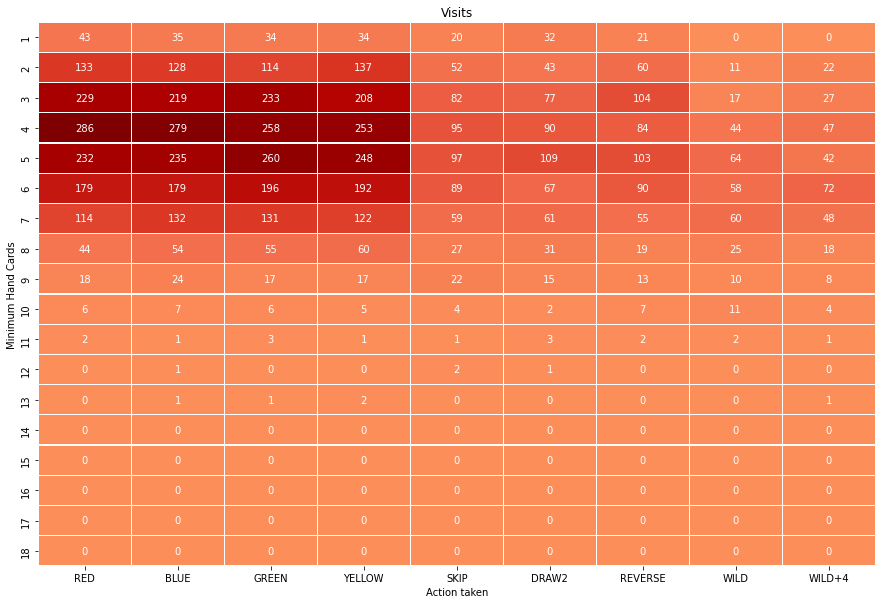

In [ ]:
visit = agent.visited.copy()

# Data prep
visit["HAND"] = visit.index.map(lambda x: sum(x[1:10]))
visit = visit.replace(0, np.NaN)
visit = visit.groupby("HAND").sum()
visit.index = visit.index.astype(int)


# Plotting
fig, ax = plt.subplots(1, 1, figsize = (15,10))

sns.heatmap(visit, 
            fmt= ",.0f", 
            cmap = "OrRd", 
            linewidth = 0.3, 
            annot = True,
            cbar = False,
            center = 0.1)

ax.title.set_text("Visits")
ax.set(xlabel="Action taken", ylabel="Minimum Hand Cards")
plt.show()

In [ ]:
# Model files
if algorithm == 'Q Learning':
  q_table.to_csv('q_learning.csv', sep = ";")
  agent.visited.to_csv('q_learning_visited.csv', sep = ";")
else:
  q_table.to_csv('monte_carlo.csv', sep = ";")
  agent.visited.to_csv('monte_carlo_visited.csv', sep = ";")